## 0. Overview

Please set out the selected data set/s you will use for your analysis.

<br>
<div class="alert alert-success">
<b>Introduction</b> 

The business problem we aim to solve in this notebook is related to predicting the electricity usage of 370 clients, on behalf of an electricity provider. This is from the "UCI Electricity Load" dataset, in which the data stretches from January 1st 2011 to January 1st 2015. We will take an ensemble and neural network-based approach.

With this data, we aim to find a model that is proficient at predicting the next value in this time series. We start by applying a linear model to this data, before trying some ensemble, bagging and boosting methods, and finally we'll use an LSTM and specialised non-linear algorithms on our data.


Out of all these models, we choose the best data and evaluate its performance further.
</div>

## 1. Problem Description

<br>
<div class="alert alert-success">
<b>How will we define our problem?</b> 

We have a dataset with many different clients in it, and we would like to know a way in which we can predict future electricity consumption using this data.

We hypothesise that our data supplied is linked to time in some way. In other words, we think that there is some link between the current electricity usage and the usage of the recent past. We hope to show this through our models - that we can predict future usage more accurately than a naive estimate using previous data.

Since these data are very numerous, we have decided to make our dataset smaller by only focusing on one client for our validation stage level of model selection. We randomly chose this client to be client MT_237.
For our final model evaluation, we will try our model on several different clients.

</div>

In [1]:
!pip install keras
!pip install fbprophet

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from itertools import compress
from matplotlib import pyplot
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from fbprophet import Prophet

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.optimizers import Adam

Using TensorFlow backend.
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (t

## 2. Experimental Setup

<br>
<div class="alert alert-success">
<b>Loading</b> 

We load our data in here
</div>

In [3]:
# problem selection - chose a paper 
data = pd.read_csv('/Users/alitaimurshabbir/Desktop/LD2011_2014.txt', sep=";", decimal=",")

data.columns = ["Date"] + list(data.columns[1:])

# We convert the "Date" column to a datetime type
data["Date"] = pd.to_datetime(data["Date"])

# We have a peek at the entire dataset
data.head()

# set out the data set and what your trying to achieve 

,Date,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
0,2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2011-01-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2011-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2011-01-01 01:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<br>
<div class="alert alert-success">
<b>Resampling</b> 

For our models, we must downsample our data in order to complete all our desired computations within the timeframe of this assignment. We will downsample it from 15-min rates into daily rates.

</div>

In [4]:
data = data.set_index("Date")
data = data.resample("D").sum()
data.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<br>
<div class="alert alert-success">
<b>Arbitrary constraint on amount of data looked at</b> 

In order to do our initial calculations, we decide to focus on a random client (essentially feature) from our dataset.
</div>

In [5]:
select_client = "MT_237"
selected_series = data[select_client]

def get_train_val_test_split_series(input_series):
    # We find the point at which they start receiving electricity
    first_non_zero = list(compress(range(len(input_series)), input_series>0))[0]
    non_zero_size = len(input_series) - first_non_zero
    # We decide the ratio to split our data with (50:50 here)
    train_size = int(non_zero_size * 0.66)
    # We find the split point and split our data
    train_split_point = first_non_zero + train_size
    train, test = list(input_series[first_non_zero:train_split_point]), list(input_series[train_split_point:])

    train_full = train

    train_train_size = int(len(train) * 0.50)
    # We find the split point and split our data
    train, val = list(selected_series[0:train_train_size]), list(selected_series[train_train_size:])
    
    return train, test, val
    
train, val, test = get_train_val_test_split_series(selected_series)

## 3. Naive forecast

<div class="alert alert-success">
<b>Naive</b> 

We create a model that simply predicts the validation set value using the previous value from the validation set. This will be our baseline against which we compare other models.

We can see that the residuals of this data are fairly evenly distributed around the y axis.
</div>

RMSE: 541.778


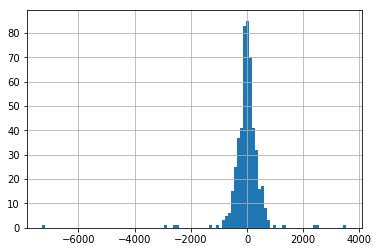

In [6]:
val_data_left_shifted = [train[len(train)-1]]+val[0:len(val)-1]

# report performance
rmse = sqrt(mean_squared_error(val_data_left_shifted, val))
print('RMSE: %.3f' % rmse)
# Plot residuals of this method
pd.Series(np.array(val)-np.array(val_data_left_shifted)).hist(bins=100)

## 4. Data Analysis

<div class="alert alert-success">
<b>Inspection</b> 

Here, we inspect our data. We choose 3 clients at random whose data we visualise.

We only visualise the training and validation sets of data, so as to not bias ourselves by looking at the holdout testing data until model evaluation.

We start by looking at the entire training+validation dataset, before zooming in to see that there appears to be some weekly seasonality to our data (period of 7). We will explore this further in a moment.

We can also see some annual seasonlity to the data as well.

Both of these observations make intuitive sense. People are more likely to watch TV all day on Saturday than Tuesday, and are more likely to be warming up near a heater in December than July.

We take a moving average plot of these data as well in order to visualise the longer term trends. These plots show the annual trends more clearly.

Finally, we also look at the distribution of usage for these three random clients. We can see two clients have a fairly normally distrubuted usage, whilst one has a very bimodal distrubution.

We find these clients and the variation between them to be somewhat representative of the whole dataset, hence their appropriateness of their use here.
</div>

In [7]:
select_clients = ["MT_237","MT_078","MT_129"]

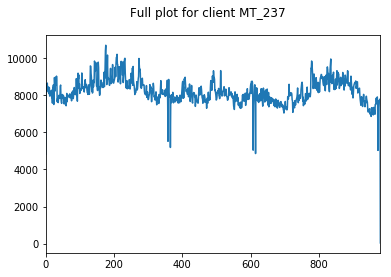

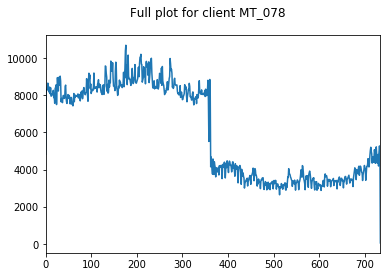

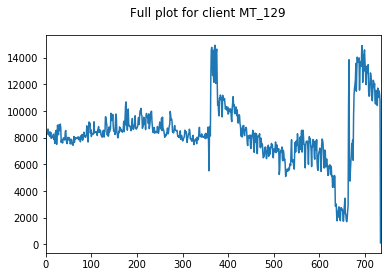

In [8]:
for client in select_clients:
    plt.figure()
    client_train, client_val, client_test = get_train_val_test_split_series(data.loc[:, client])
    pd.Series(client_train+client_val).plot(title="Full plot for client "+client, subplots=True)

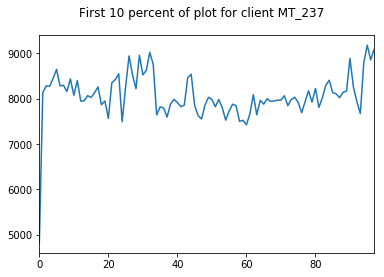

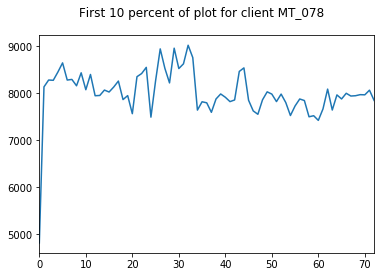

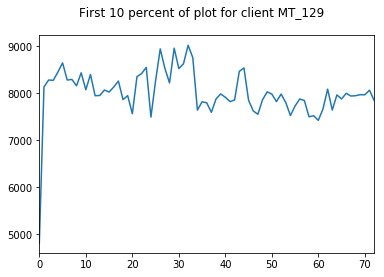

In [9]:
for client in select_clients:
    plt.figure()
    client_train, client_val, client_test = get_train_val_test_split_series(data.loc[:, client])
    pd.Series(list(client_train+client_val)[0:(int(len(list(client_train+client_val))/10))]).plot(title="First 10 percent of plot for client "+client, subplots=True)

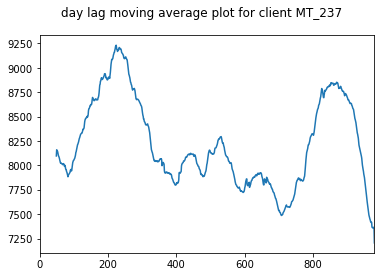

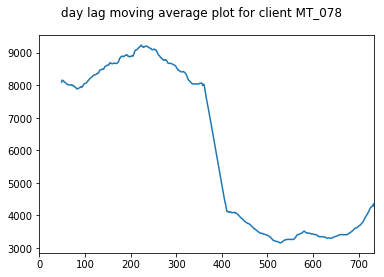

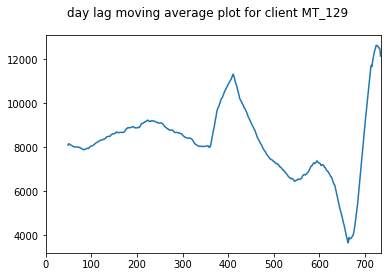

In [10]:
for client in select_clients:
    plt.figure()
    client_train, client_val, client_test = get_train_val_test_split_series(data.loc[:, client])
    pd.Series(client_train + client_val).rolling(50).mean().plot(title="day lag moving average plot for client "+client, subplots=True)

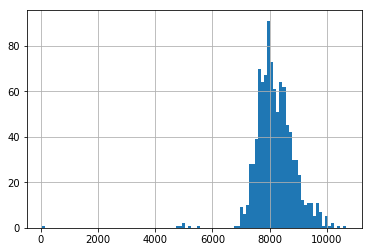

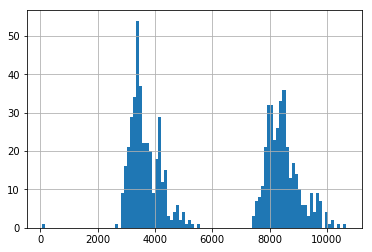

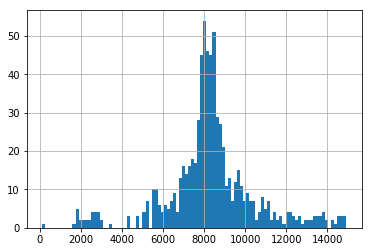

In [11]:
for client in select_clients:
    plt.figure()
    
    client_train, client_val, client_test = get_train_val_test_split_series(data.loc[:, client])
    pd.Series(client_train+client_val).hist(bins=100)

In [12]:
del select_clients

## 5. Linear Models

<br>
<div class="alert alert-success">
<b>Linear Models</b> 

<p>As we have seen from our previous visualisation, there are three clear time trends in our data.<p>
<p>In order to use some of our linear models, we require stationarity from our data. Therefore, we need to do daily, weekly and annual differencing on our data.<p>
<p>Here, we will difference and test the stationarity of one client explicitly for several levels of timescale.<p>

</div>

ADF Statistic for no differenced dataset: -2.690976
p-value: 0.075613
Critical Values:
	1%: -3.444
	5%: -2.868
	10%: -2.570
ADF Statistic for weekly differenced dataset: -7.465828
p-value: 0.000000
Critical Values:
	1%: -3.445
	5%: -2.868
	10%: -2.570


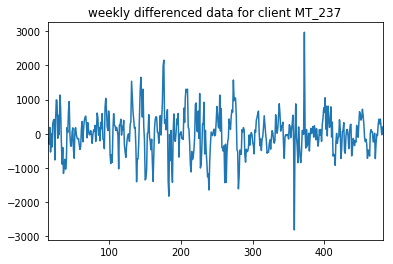

In [13]:
diffs = pd.Series(train)

result = adfuller(diffs)
print('ADF Statistic for no differenced dataset: %f' % result[0]) 
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value)) 

timescales = {"weekly": 7}

for i, (timescale, period_value) in enumerate(timescales.items()):
    diffs = diffs.diff(periods=period_value)
    
    first_non_zero = list(compress(range(len(diffs)), diffs>0))[0]

    diffs = diffs[first_non_zero:]
    
    plt.figure()
    diffs[first_non_zero:].plot(title=timescale+" differenced data for client "+select_client)
    result = adfuller(diffs)
    print('ADF Statistic for '+timescale+' differenced dataset: %f' % result[0]) 
    print('p-value: %f' % result[1])
    print('Critical Values:')

    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value)) 

<br>
<div class="alert alert-success">
<b>Linear Models</b> 

<p>We can see that after we take the weekly difference of the data, we get a marked increase in stationarity.
Before this differencing, we did not have statistically significant (to 5%) stationary data, but after differencing, this data became statistically significantly stationary.
<p>
    
<p>Next, we want to plot the autocorrelation function and the partial autocorrelation function for our data to get a sense of what values we should assign to p and q in our ARIMA(p,d,q) model.<p>

</div>

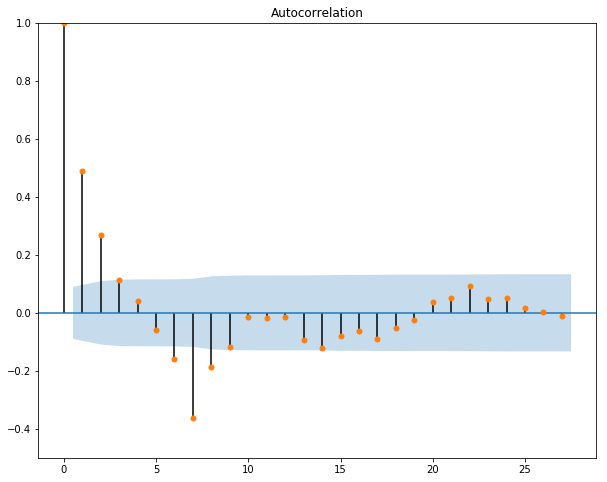

In [14]:
# ACF and PACF plots of time series
from pandas import Series
from statsmodels.graphics.tsaplots import plot_acf 
from statsmodels.graphics.tsaplots import plot_pacf 

pyplot.figure(6,figsize=(10, 8))
pyplot.plot(211)
pyplot.ylim([-0.5,1])
plot_acf(diffs, ax=pyplot.gca())
pyplot.show()

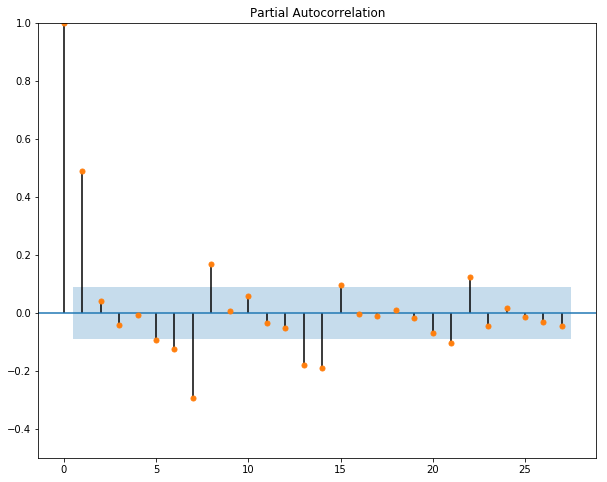

In [15]:
pyplot.figure(7,figsize=(10, 8)) 
pyplot.plot(212)
pyplot.ylim([-0.5,1])
plot_pacf(diffs, ax=pyplot.gca(), method="ywmle")
pyplot.show()

<br>
<div class="alert alert-success">
<b>Linear Models</b> 

<p> We can see from our acf graph that the only value that has a large correlation (negative or positive) is the first lag. Hence, we set our p to be 1.<p>
    
<p> We can see from our pacf graph that the only really significant value for our dataset is the first lagged point. Therefore, we will set q=1 for our ARIMA function.<p>
    
<p>Since our dataset is already differenced and satisfactorily stationary, we set d=0.<p>
    
</div>

In [16]:
# evaluate manually configured ARIMA model
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt

def inverse_difference(prediction, history, weekly=True):
    history = pd.Series(history)
    
    current_index = len(history)

    if weekly:
        weekly_differenced = history
        prediction = prediction + weekly_differenced[current_index-7+1]

    return prediction

# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    
    # difference data in terms of days, weeks, then years
    diff = list(pd.Series(history).diff(periods=7).dropna())
    
    yhat = inverse_difference(test, history, len(predictions)+1)
    
    # predict
    model = ARIMA(diff, order=(1, 0, 1))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    yhat = inverse_difference(yhat, history)
    predictions.append(yhat)
    
    # observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
    
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=8254.066, Expected=8064
>Predicted=7980.689, Expected=7780
>Predicted=7528.386, Expected=7779
>Predicted=7806.572, Expected=7600
>Predicted=7747.945, Expected=7836
>Predicted=7722.892, Expected=7866
>Predicted=8091.508, Expected=7934
>Predicted=7873.926, Expected=7841
>Predicted=7666.974, Expected=8295
>Predicted=7860.103, Expected=8235
>Predicted=8077.822, Expected=8241
>Predicted=8204.114, Expected=8772
>Predicted=8429.125, Expected=9127
>Predicted=8513.448, Expected=9405
>Predicted=9092.669, Expected=9162
>Predicted=8966.903, Expected=10154
>Predicted=9272.979, Expected=9549
>Predicted=9531.133, Expected=8515
>Predicted=9307.183, Expected=9887
>Predicted=10010.339, Expected=9761
>Predicted=9536.726, Expected=8886
>Predicted=9897.362, Expected=8742
>Predicted=9311.409, Expected=8618
>Predicted=7679.820, Expected=8356
>Predicted=9202.097, Expected=8446
>Predicted=9693.921, Expected=9459
>Predicted=8652.685, Expected=9068
>Predicted=8358.605, Expected=9417
>Predicted=8881.81

<br>
<div class="alert alert-success">
<b>ARIMA results</b> 

<p> From the results of this ARIMA model, we can see that our model is much worse than the naive baseline.
Our ARIMA RMSE is 672.9, whilst our naive RMSE is 541.8.<p>
<p> One reason for this poor performance could be that our p, d and q values are not optimal for our dataset. One way to find the optimal values for these hyperparameters would be to do a grid search. We do this in the treatment of our other dataset in our other notebook, where we explore the ARIMA model in more depth.<p>

</div>

## 6. Supervised Learning formulation

<br>
<div class="alert alert-success">
<b>Supervised learning</b> 

<p> In order to prepare our data for supervised learning, we must create a dataframe with lagged values as features and the target current data value.<p>
<p>Here, we choose a lag window of 3 (4 minus the current data point) because in imperical testing with the later LSTM model, this was shown to be the most performant.<p>
<p>Choosing a value with which to modify all data based on evidence from one model is not scientifically rigourous. If we had more time, we would try all our models with multiple different lag values in order to see which value works best with each model.<p>
<p>However, due to the time limitations of the assignment and the need to reduce complexity, the value of 3 lags was found to be appropriate for our problem across all models. This time window allows for quick computation and allows for good performance across all models.<p>
<p>This choice of a different lag value to that of ARIMA (ARIMA had a lag value of 1 for both p and q values) makes comparison of these values somewhat limited. We attempted to run ARIMA with a lag value of 3, but were greeted with an error saying that ARIMA did not converge. Hence, we stuck with a lag of 1.
In any case, the performance of ARIMA is so much worse than that of all the other models that we do not seek to compare them in this notebook.
Please see the other notebook for a more thorough comparison between modern models and the ARIMA model.<p>

</div>

In [17]:
shifted_series_list = []

window_lag_plus_current = 4

non_zero_data = pd.Series(train+val+test)

for i in range(window_lag_plus_current):
    shifted_series_list.append(non_zero_data.shift(i))

# We turn previous time steps into a feature in our supervised learning dataframe
supervised_learning_df = pd.concat(shifted_series_list, axis=1)
lag_labels = ["time_lag_"+str(lag) for lag in range(1,window_lag_plus_current)]
supervised_learning_df.columns = ["current_value"]+lag_labels

supervised_learning_df = supervised_learning_df.dropna()

dataset_length = supervised_learning_df.shape[0]

first_split = int(dataset_length*0.67)

supervised_learning_train_X = supervised_learning_df.loc[0:first_split, lag_labels].reset_index(drop=True)
supervised_learning_train_y = supervised_learning_df.loc[0:first_split, "current_value"].reset_index(drop=True)
supervised_learning_test_X = supervised_learning_df.loc[first_split:, lag_labels].reset_index(drop=True)
supervised_learning_test_y = supervised_learning_df.loc[first_split:, "current_value"].reset_index(drop=True)

<br>
<div class="alert alert-success">
<b>Models</b> 

<p> Here, we try and fit our data to a selection of regression models in order to compare performance. We split our data into three folds, each of which we perform walk forward validation with. This gives us a robust value for our RMSE, and shows us which models are consistently better than which other models.<p>
    
<p>The hyperparameters for these models were chosen by fiddling with them to see which ones afforded the best results. If we were being more rigorous, we would have done grid search over each model for each split to find the optimal configuration of hyperparameters for each model.<p>
    
</div>

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import TimeSeriesSplit

# We create a function to apply different models to the same data several times
def apply_sklearn_model_to_train_and_val(model, train_X_input, train_y_input, verbose=False):
    
    splits = TimeSeriesSplit(n_splits=3)
    
    rmses = []
    
    # We split our data into 3 folds which are temporally consistent. This gives us a more robust RMSE score
    for train_index, test_index in splits.split(train_X_input):
        
        train_X = train_X_input.loc[train_index,]
        val_X = train_X_input.loc[test_index,]
        train_y = train_y_input[train_index]
        val_y = train_y_input[test_index]
        
        model.fit(train_X, train_y)
        
        # walk-forward validation
        history = train_X
        history_y = list(train_y)
        predictions = list()
        for i in list(val_X.index):
            
            # We refit our data at each time step with the data from the last time step included
            model.fit(history, history_y)

            current_data = pd.DataFrame(val_X.loc[i,:]).T
            
            # We make a new prediction for our data
            yhat = model.predict(current_data)
            predictions.append(yhat)
            # observation    
            obs = val_y.loc[i]

            history = history.append(current_data)
            history_y.append(obs)
            if verbose:
                print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))

        # report performance
        rmse = sqrt(mean_squared_error(val_y, predictions))
        print('RMSE: %.3f' % rmse)
        
        rmses.append(rmse)
        
    return rmses

# We have several models that we try to fit the data to
models = {"Random forest": RandomForestRegressor(max_depth=4, random_state=0, n_estimators=50),
          "Ridge regression": Ridge(alpha=.3),
          "K nearest neighbours": KNeighborsRegressor(n_neighbors=5),
          "AdaBoost": AdaBoostRegressor(n_estimators=100),
          "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0, loss='ls'),
          "Perceptron": MLPRegressor(hidden_layer_sizes=(30,), max_iter=200)
}

model_performance = {}

for model_name, model in models.items():
    print(model_name)
    
    accuracy = apply_sklearn_model_to_train_and_val(model, 
                                                     supervised_learning_train_X, 
                                                     supervised_learning_train_y)
    
    model_performance[model_name] = accuracy

Random forest


<br>
<div class="alert alert-success">
<b>Supervised Learning Results</b> 

<p>We can see that our Gradient Boosting algorithm has the consistently best results, closely followed by the Random Forest algorithm.<p>
<p>We can see that Gradient Boosting, Random Forest, K-nearest neighbours and AdaBoost have performances higher than that of the naive forecast, whilst Ridge Regression's performance is almost the same as that of the naive forecast.<p>
<p>The perceptron model was a poor predictor of future values. The model rarely converged, so perhaps given more iterations, it would have found a more accurate solution. In any case, there was not enough time to implement this in this assignment. However, the LSTM results in the next section show that a neural approach to this problem is not invalid.<p>
    
</div>

In [ ]:
performance_output = pd.DataFrame(model_performance).T

performance_output["mean"] = performance_output.T.mean()

performance_output.sort_values("mean")

## 8. Advanced Methods 

<br>
<div class="alert alert-success">
<b>Advanced Learning</b> 

<p>Here, we apply Keras' LSTM model to our dataset in the same manner as that of the supervised learning before to make the two results comparable.<p>
<p>The architecture for our LSTM network was chosen via trial and error, as were the hyperparameters. If this was a more rigorous treatment, we would try configurations of many different architectures and hyperparameters to optimise performance.<p>
    
</div>

In [ ]:
# We create our splits for our time series

splits = TimeSeriesSplit(n_splits=3)
    
rmses = []
    
# We split our data into 3 folds which are temporally consistent. This gives us a more robust RMSE score
for train_index, test_index in splits.split(supervised_learning_train_X):
    
    # We split our training data into training and validation sets
    lstm_train_x = supervised_learning_train_X.loc[train_index,]
    lstm_val_x = supervised_learning_train_X.loc[test_index,]
    lstm_train_y = supervised_learning_train_y[train_index]
    lstm_val_y = supervised_learning_train_y[test_index]
    
    # We scale our data in order for Keras to process it efficiently
    # THIS IS VERY IMPORTANT - without this, the LSTM keeps failing to converge and is generally useless
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    lstm_train_X_scaled = scaler_X.fit_transform(lstm_train_x)
    lstm_val_X_scaled = scaler_X.transform(lstm_val_x)
    lstm_train_y_scaled = scaler_y.fit_transform(pd.DataFrame(lstm_train_y))
    lstm_val_y_scaled = scaler_y.transform(pd.DataFrame(lstm_val_y))

    lstm_train_X_scaled = np.reshape(np.array(lstm_train_X_scaled), (lstm_train_X_scaled.shape[0], 1, lstm_train_X_scaled.shape[1]))
    lstm_val_X_scaled = np.reshape(np.array(lstm_val_X_scaled), (lstm_val_X_scaled.shape[0], 1, lstm_val_X_scaled.shape[1]))

    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(10, input_shape=(1, window_lag_plus_current-1)))
    model.add(Dense(10))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    #adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.99, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss='mean_squared_error', optimizer="adam")
    model.fit(lstm_train_X_scaled, lstm_train_y_scaled, epochs=100, batch_size=20, verbose=1, validation_split=0.2)
    
    preds = scaler_y.inverse_transform(model.predict(lstm_val_X_scaled))
    trues = lstm_val_y

    rmse = sqrt(mean_squared_error(preds, trues))
    
    rmses.append(rmse)

In [ ]:
avg_rmse = sum(rmses)/len(rmses)

print("The RMSE of our LSTM model is: {0}".format(avg_rmse))
performance_output_updated = performance_output.append(pd.DataFrame({"LSTM": rmses+[avg_rmse]}, index=performance_output.columns).T).sort_values("mean")

performance_output_updated

<br>
<div class="alert alert-success">
<b>LSTM results</b> 

<p>We can see that our LSTM has good performance, almost as good as that of Gradient Boosting, and just a bit better than Random Forests. It outperforms the naive forecast very well.<p>
<p>Further experimentation with architectures and implementations of RNNS (E.g. using a GRU instead of an LSTM) could lead to both speed and accuracy boosts for this network.<p>
    
</div>

<br>
<div class="alert alert-success">
<b>Facebook Prophet</b> 

<p>We applied the Facebook Prophet algorithm to this problem too. The performance of this alogirthm was not great given the time needed for this algorithm (>45 mins). We achive a mean RMSE of 623.7, which is much worse than our naive baseline and is only better than our Perceptron out of our supervised learning models. We find that the LSTM or the gradient boosting algorithm to be the best model in our stable of models just now.<p>
    
</div>

In [ ]:
split = int(len(selected_series)*0.67)

X_train = selected_series[0:split]
X_test = selected_series[split:]

splits = TimeSeriesSplit(n_splits=3)

rmses = []

# We split our data into 3 folds which are temporally consistent. This gives us a more robust RMSE score
for train_index, test_index in splits.split(X_train):
    
    train_X = X_train[train_index]
    val_X = X_train[test_index]
    
    prophet_df = pd.DataFrame({"ds":train_X.index, "y":train_X.values})
    
    predictions = []
    
    for i in list(val_X.index):
        
        # We refit our data at each time step with the data from the last time step included
        m = Prophet(daily_seasonality=False, yearly_seasonality=False)
        m.fit(prophet_df)

        future = m.make_future_dataframe(periods=1)
        forecast = m.predict(future)
        forecast_estimate = forecast["yhat"][forecast.shape[0]-1]

        # We make a new prediction for our data
        predictions.append(forecast_estimate)
        # observation    
        obs = val_X[i]
        prophet_df = prophet_df.append(pd.DataFrame({"ds":[i], "y":[obs]}))

        print('>Predicted=%.3f, Expected=%3.f' % (forecast_estimate, obs))

    # report performance
    rmse = sqrt(mean_squared_error(list(val_X), predictions))
    print('RMSE: %.3f' % rmse)
        
    rmses.append(rmse)

In [ ]:
avg_rmse = sum(rmses)/len(rmses)

print("The RMSE of our Prophet model is: {0}".format(avg_rmse))
performance_output_updated_prophet = performance_output_updated.append(pd.DataFrame({"FB Prophet": rmses+[avg_rmse]}, index=performance_output.columns).T).sort_values("mean")

performance_output_updated_prophet

<br>
<div class="alert alert-success">
<b>Evaluation</b> 

<p>Since we have found the Gradient Boosting regressor to be our best model, we will now perform grid search over it to find the optimal parameters for this model. Then we will apply this model to our holdout dataset to evaluate the model's real world performance.<p>
<p>We first find the naive baseline for the test data, which turns out to be and RMSE of 599.7.<p>
<p>We find our Gradient Boosting algorithm to far outstrip this RMSE. We find the optimal confiiguration of hyperparameters for this algorithm to be XXXXXXX, with an associated RMSE of YYYYYYYY.<p>
    
</div>

In [ ]:
test_data_left_shifted = [val[len(val)-1]]+test[0:len(test)-1]

# report performance
rmse = sqrt(mean_squared_error(test_data_left_shifted, test))
print('RMSE: %.3f' % rmse)
# Plot residuals of this method
pd.Series(np.array(test)-np.array(test_data_left_shifted)).hist(bins=100)

In [ ]:
estimators = [50, 100, 200]
learning_rate = [0.01, 0.1, 0.3]
max_depth = [1, 3, 5]

results = np.zeros((len(estimators),len(learning_rate),len(max_depth)))

for estimators_counter in range(len(estimators)):
    for lr_counter in range(len(learning_rate)):
        for depth_counter in range(len(max_depth)):
            
            GBR = GradientBoostingRegressor(n_estimators=estimators[estimators_counter], learning_rate=learning_rate[lr_counter], max_depth=max_depth[depth_counter], random_state=0, loss='ls')

            # walk-forward validation
            history = supervised_learning_train_X
            history_y = list(supervised_learning_train_y)
            predictions = list()
            for i in list(supervised_learning_test_X.index):

                # We refit our data at each time step with the data from the last time step included
                GBR.fit(history, history_y)

                current_data = pd.DataFrame(supervised_learning_test_X.loc[i,:]).T

                # We make a new prediction for our data
                yhat = GBR.predict(current_data)
                predictions.append(yhat)
                # observation    
                obs = supervised_learning_test_y.loc[i]

                history = history.append(current_data)
                history_y.append(obs)

            # report performance
            rmse = sqrt(mean_squared_error(supervised_learning_test_y, predictions))
            
            results[estimators_counter][lr_counter][depth_counter] = rmse

<br>
<div class="alert alert-success">
<b>Conclusion</b> 

<p>We have found the Gradient Boosting Regressor to be our best model which most accurately forecasts the electricty usage of clients in Portugal given their electricity usage history.<p>
    
</div>